# Parallel runs
A **static** graph in which nodes are run in parallel and results are aggregated by another node. 

* Voting pattern e.g., pick the best article 
* Subtasks - break the task into multiple tasks e.g., flight, hotel & car rental
* Distributed processing e.g., summarization task for a large corpus; "map-reduce" workflow where your graph invokes the same node multiple times in parallel with different states, before aggregating the results back into the main graph's state.

### Send API

https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send

The **Send** API can also be used for creating dynamic parallel graphs.

* Invoked in a regular node
* Schema for subtasks may be different from parent's schema; differentiates from conditional edges where the schema stays the same
* Send takes the node and state for the task


https://langchain-ai.github.io/langgraph/tutorials/workflows/?h=par#parallelization

Pattern:
* [Parallelization](https://langchain-ai.github.io/langgraph/tutorials/workflows/?h=par#parallelization)
* [Orchestrator-Worker](https://langchain-ai.github.io/langgraph/tutorials/workflows/?h=par#orchestrator-worker)
* 

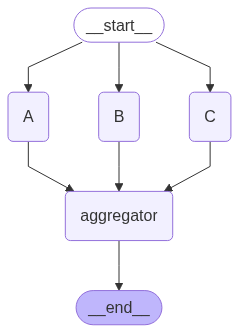

Processor generated: 2
Processor generated: 5
Processor generated: 8
It took 8 seconds.


In [2]:
from langgraph.graph import StateGraph, START, END
from typing import List, Annotated, TypedDict
from IPython.display import Image, display
import random
import operator
import time

# Reducer function : appends the number to list[int]
def append_to_list(current: List[int], new: List[int])->List[int]:
    return current + new

# State schema
class StateParallel(TypedDict):
    total: Annotated[int, operator.add]
    numbers: Annotated[List[int], append_to_list]

# Nodes : Same node
def processor_node(state: StateParallel)->StateParallel:
    rint = random.randint(1, 10)
    # Simulate artificial processing delays
    time.sleep(rint)
    print(f"Processor generated: {rint}")
    return {"numbers": [rint]}

def aggregator_node(state: StateParallel)->StateParallel:
    nums = state["numbers"]
    return {"total": sum(nums)}

# Graph
parallel_graph = StateGraph(StateParallel)

# Add nodes
parallel_graph.add_node("A", processor_node)
parallel_graph.add_node("B", processor_node)
parallel_graph.add_node("C", processor_node)
parallel_graph.add_node("aggregator", aggregator_node)

# Add edges
parallel_graph.add_edge(START,"A")
parallel_graph.add_edge(START,"B")
parallel_graph.add_edge(START,"C")

parallel_graph.add_edge("A","aggregator")
parallel_graph.add_edge("B","aggregator")
parallel_graph.add_edge("C","aggregator")

parallel_graph.add_edge("aggregator",END)

# Compile
parallel_graph_compiled = parallel_graph.compile()

# Display
display(Image(parallel_graph_compiled.get_graph().draw_mermaid_png()))

# Invoke
start_time = time.time()
parallel_graph_compiled.invoke({"total": 0, "numbers": []})
end_time = time.time()

print(f"It took {int(end_time - start_time)} seconds.")

## Send API
https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send

Create a graph that would invoke the same processing logic in parallel. The number of parallel tasks is determined by a state attribute.

https://dev.to/sreeni5018/leveraging-langgraphs-send-api-for-dynamic-and-parallel-workflow-execution-4pgd
https://medium.com/@astropomeai/implementing-map-reduce-with-langgraph-creating-flexible-branches-for-parallel-execution-b6dc44327c0e

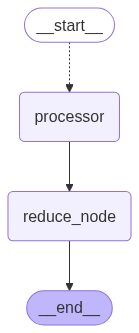

Task started: task-0
Task started: task-1
Task started: task-2
Task started: task-3
Task started: task-4
Reducer received : {'rint': [3, 4, 2, 4, 7], 'name': ['task-0', 'task-1', 'task-2', 'task-3', 'task-4']}


{'tasks': 5,
 'total': 20,
 'result': [{'name': 'task-0', 'rint': 3},
  {'name': 'task-1', 'rint': 4},
  {'name': 'task-2', 'rint': 2},
  {'name': 'task-3', 'rint': 4},
  {'name': 'task-4', 'rint': 7}]}

In [3]:
from langgraph.types import Send
import operator
import random
# from pydantic import BaseModel, Field

# class Result(BaseModel):
    

class StateParallelSend(TypedDict):
    tasks: int
    total: int
    result: dict

# Attributes must be annotated as multiple tasks will be updating the state
class TaskState(TypedDict):
    rint: Annotated[list[int], operator.add]
    name: Annotated[list[str], operator.add]
    
def processor(state: TaskState):
    print(f"Task started: {state["name"]}")
    # print(f"message from {state["name"]}")
    rint = random.randint(1, 10)
    return {"rint": [rint], "name": [state["name"]]}

# Router logic
def map_node(state: StateParallelSend):
    sends = []
    for i in range(state["tasks"]):
        name = f"task-{i}"
        sends.append(Send("processor", {"name": name} ))
    return sends

def reduce_node(state: TaskState):
    print(f"Reducer received : {state}")

    # transform the received results from processors
    result = []
    total = 0
    for i in range(len(state["name"])):
        result.append({"name": state["name"][i], "rint": state["rint"][i]})
        total += state["rint"][i]
    return {"total": total, "result": result}

workflow_map_reduce = StateGraph(StateParallelSend)

# workflow_map_reduce.add_node("map_node",map_node) # map_node)
workflow_map_reduce.add_node("processor",processor)

# add reduce node
workflow_map_reduce.add_node("reduce_node",reduce_node)

# workflow_map_reduce.add_conditional_edges(START, map_node,["processor"])
workflow_map_reduce.add_conditional_edges(START, map_node,["processor"])

# add edge to reducer node
workflow_map_reduce.add_edge("processor", "reduce_node")

workflow_map_reduce_compiled = workflow_map_reduce.compile()

display(Image(workflow_map_reduce_compiled.get_graph().draw_mermaid_png()))

workflow_map_reduce_compiled.invoke({"tasks": 5})

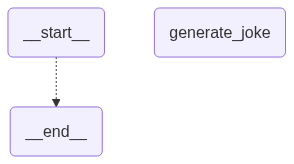

{'subjects': ['cats', 'dogs'], 'jokes': ['Joke about cats', 'Joke about dogs']}

In [4]:
from typing import Annotated
import operator
from IPython.display import Image, display

class OverallState(TypedDict):
     subjects: list[str]
     jokes: Annotated[list[str], operator.add]

from langgraph.types import Send
from langgraph.graph import END, START

def continue_to_jokes(state: OverallState):
     return [Send("generate_joke", {"subject": s}) for s in state['subjects']]

from langgraph.graph import StateGraph
builder = StateGraph(OverallState)
builder.add_node("generate_joke", lambda state: {"jokes": [f"Joke about {state['subject']}"]})
builder.add_conditional_edges(START, continue_to_jokes)
builder.add_edge("generate_joke", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

# Invoking with two subjects results in a generated joke for each
graph.invoke({"subjects": ["cats", "dogs"]})
# {'subjects': ['cats', 'dogs'], 'jokes': ['Joke about cats', 'Joke about dogs']}